# HW 8.3


## 8.10

Add a method <code>estimate</code> to your <code>LinearModel</code> class to use the Kalman filter to estimate a state sequence corresponding to a given observation sequence <code>y</code> and initial state extimate <code>x0</code>

In [38]:
import numpy as np
from matplotlib import pyplot as plt

In [34]:
class LinearModel(object):
    def __init__(self, F, Q, H, R, u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : (n,n) ndarray -- State transition model
        Q : (n,n) ndarray -- Covariance matrix for state noise
        H : (m,n) ndarray -- Observation model
        R : (m,m) ndarray -- Covariance matrix for observation noise
        u : (n,) ndarray -- Control vector
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        
        self.n = F.shape[0]
        self.m = R.shape[0]
        
    
    def evolve(self, x0, N):
        """
        Compute the first N states and observations 
        generated by the linear system.
        
        Parameters
        ----------
        x0 : (n,) ndarray -- The initial state
        N : int -- The number of steps to evolve.
        
        Returns
        -------
        states : (n,N) ndarray -- States 0 through N-1, given by each column
        obs : (m,N) ndarray -- Observations 0 through N-1, given by each column
        """
        # note, here we build the states transposed, where each state is a row
        states = np.empty((N,self.n))
        obs = np.empty((N,self.m))
        states[0] = x0
        obs[0] = self.H @ x0 + np.random.multivariate_normal(np.zeros(self.m), self.R)
        
        for i in range(N-1):
            states[i+1] = self.F @ states[i] + self.u + np.random.multivariate_normal(np.zeros(self.n),self.Q)
            obs[i+1] = self.H @ states[i+1] + np.random.multivariate_normal(np.zeros(self.m), self.R)
            
        return states.T, obs.T
    
    def estimate(self, x0, P, y):
        """
        comupte the state etsimates using the Kalman filter.
        If x0 and P correspond to time step k, then y is a sequence of
        observations starting at time step k+1.
        
        Parameters
        ----------
        x0 : array (n) - The initial state estimate
        P : matrix (n,n) - The initial error covariance matrix.
        y : matrix (m,N) - Sequence of N observations, each column an obs
        
        Returns
        -------
        out : array (n,N) - Sequence of state estimates, each column an estimate
        """
        x = [x0]
        P = P.copy()
        
        for yk in y.T:
            # Predictive step
            pred_x = self.F @ x[-1] + self.u
            pred_P = self.F @ P @ self.F.T + self.Q
            
            # Update step
            P = np.linalg.inv(np.linalg.inv(pred_P) + self.H.T @ np.linalg.inv(self.R) @ self.H)
            x.append( pred_x - P @ self.H.T @ np.linalg.inv(self.R) @ (self.H @ pred_x - yk) )
            
        return np.array(x).T

## 8.11

Returning to the projectile example, assume that the radar sensor has taken observations from time steps 200 through 800 (take the corresponding slice of the observations produced in 8.8). Use these observatinos to estimate the corresponding true states of the projectile at those times.

(i.) Construct an estimate $\hat{x}_{200}$ for state 200 as follows: For the horizontal and vertical positions, simply use the observed position at time 200. For the velocity, compute the average velocity between the ovservations for $k = 200, ..., 208$.


In [35]:
# Instantiate a la 8.2.6
timestep = 0.1

F = np.eye(4) + np.diag([timestep, timestep], k=2)
Q = 0.1 * np.eye(4)
H = np.hstack((np.eye(2), np.zeros((2,2))))
R = 5000 * np.eye(2)
u = np.array([0,0,0,-9.8 * timestep])
x0 = np.array([0,0,300,600])
model = LinearModel(F,Q,H,R,u)

# Get the first 800 states and observations
x, y = model.evolve(x0, 801)

# Estimate velocity
v = np.diff(y[:,200:209]).mean(1)

# Pick starting estimate
x_hat = np.array([*y[:,200], *v])

(ii.) Use the initial accuracy estimate $P_{200} = 10^6 \dot Q$ and feed $P_{200}, \hat{x}_{200}$, and $y_{201}, ... , y_{800}$ to the Kalman filter to obtain estimates for $x_{201}, ... , x_{800}$

In [36]:
P = 10 ** 6 * model.Q

x_predictions = model.estimate(x_hat, P, y[:, 201:801])

(iii.) Plot these state estimates as a smooth green curve together with the radar oservations (as red dots) and the entire true state sequence (as a blue curve).
Zoom in to see how well it follows the true path.

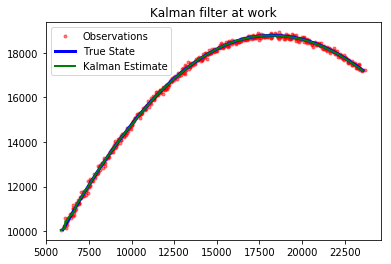

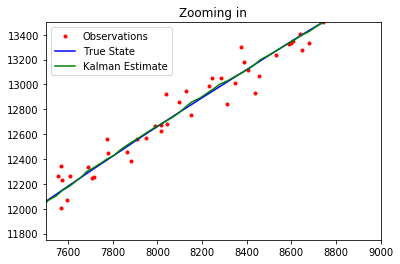

In [66]:
plt.plot(*y[:,200:801],'r.',alpha = .5, label="Observations")
plt.plot(*x[:2,200:801],'b',linewidth=3, label="True State")
plt.plot(*x_predictions[:2],'g', linewidth = 2, label="Kalman Estimate")
plt.title("Kalman filter at work")
plt.legend()
plt.show()


plt.plot(*y[:,200:801],'r.', label="Observations")
plt.plot(*x[:2,200:801],'b', label="True State")
plt.plot(*x_predictions[:2],'g', label="Kalman Estimate")
plt.title("Zooming in")
plt.legend()
plt.xlim(7500, 9000)
plt.ylim(11750,13500)
plt.show()